**IMPORTING THE LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import os


<hr style="border:4px solid pink"> </hr>

<hr style="border:4px solid pink"> </hr>


In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import torch as nn
from sklearn.model_selection import train_test_split
from torch.nn import Dropout , Linear

    CONFIG FILE

In [ ]:
### Config File
TRAIN = './train.csv'
TEST = './test.csv'
TEST_LABEL = './test_labels.csv'
SAMPLE = './sample_submission.csv'
EPOCHS = 2

**IMPORTING THE Files**

In [ ]:
train_csv = pd.read_csv(TRAIN)
test_csv = pd.read_csv(TEST)
test_label = pd.read_csv(TEST_LABEL)
sample_sub = pd.read_csv(SAMPLE)
train_csv.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train_csv.head()

In [ ]:
train_csv['toxic'].unique()

In [ ]:
train_csv['severe_toxic'].unique()

In [ ]:
train_csv['comment_text'][3]

In [ ]:
train_csv['comment_text'][5]

# Text Processing

<hr style="border:4px solid pink"> </hr>

    TEXT PREPROCESSING FOR BERT

In [ ]:
import re
def text_preprocessing(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'[0-9]+' , '' ,text)
    text = re.sub(r'\s([@][\w_-]+)', '', text).strip()
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace("#" , " ")
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [ ]:
print('Original sentence :'  , train_csv['comment_text'][3])
print('Processed Sentence :' , text_preprocessing(train_csv['comment_text'][3]))

Original sentence : "
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.

There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "
Processed Sentence : " More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents"" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any pref

In [ ]:
test_csv.head()

In [ ]:
print('Original : ' ,test_csv['comment_text'][2])
print('Processed :' , text_preprocessing(test_csv['comment_text'][2]))

Original :  " 

 == Sources == 

 * Zawe Ashton on Lapland —  /  "
Processed : " == Sources == * Zawe Ashton on Lapland  / "


In [ ]:
test_label.head()

In [ ]:
sample_sub.head()

<hr style="border:4px solid pink"> </hr>


    ANALYZING THE MOST COMMON WORD IN OUR TRAIN DATASET USING WORDCLOUD

In [ ]:
X = []
for items in train_csv['comment_text']:
    X.append(text_preprocessing(items))

In [ ]:
commonWord = ' '.join(X)

In [ ]:
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(commonWord)

In [ ]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<hr style="border:4px solid pink"> </hr>

In [ ]:
fig , axes = plt.subplots(2,3,figsize = (10,10), constrained_layout = True)
sns.countplot(ax=axes[0,0],x='toxic',data=train_csv )
sns.countplot(ax=axes[0,1],x='severe_toxic',data=train_csv)
sns.countplot(ax=axes[0,2],x='obscene',data=train_csv)
sns.countplot(ax = axes[1,0],x='threat',data=train_csv)
sns.countplot(ax=axes[1,1],x='insult',data=train_csv)
sns.countplot(ax=axes[1,2],x='identity_hate',data=train_csv)
plt.suptitle('No Of Classes Of Each Category')
plt.show()

<hr style="border:4px solid pink"> </hr>

## SPLITTING YOUR TRAIN DATA INTO TRAIN AND VALIDATION SET FOR TRAINING



In [ ]:
X = train_csv.comment_text.values
Y = train_csv.toxic.values
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=2021)

from transformers import BertTokenizer


    SETTING UP THE GPU IF POSSIBLE

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# Bert Tokenization

<hr style="border:4px solid pink"> </hr>

    Installing the Hugging Face Library

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',
            #return_tensors='pt',           # Return PyTorch tensor
            truncation = True,
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 300

token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)


Original:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Token IDs:  [np.int64(101), np.int64(7526), np.int64(2339), np.int64(1996), np.int64(10086), np.int64(2015), np.int64(2081), np.int64(2104), np.int64(2026), np.int64(5310), np.int64(18442), np.int64(13076), np.int64(12392), np.int64(2050), np.int64(5470), np.int64(2020), np.int64(16407), np.int64(1029), np.int64(2027), np.int64(4694), np.int64(1005), np.int64(1056), np.int64(3158), np.int64(9305), np.int64(22556), np.int64(1010), np.int64(2074), np.int64(8503), np.int64(2006), np.int64(2070), np.int64(3806), np.int64(2044), np.int64(1045), np.int64(5444), np.int64(2012), np.int64(2047), np.int64(2259), np.int64(14421), np.int64(6904), np.int64(2278), np.int64(1012), np.int64(1998), np.int64(3531), np.int64(2123), n

<hr style="border:4px solid pink"> </hr>




# Create the DataLoader fot train and test


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the BertClassifier


In [ ]:
%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.LSTM = nn.LSTM(D_in,D_in,bidirectional=True)
        # self.clf = nn.Linear(D_in*2,2)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            # nn.LSTM(D_in,D_in)
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


# Bert Initialization

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler."""

    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(
        bert_classifier.parameters(),
        lr=5e-5,    # Default learning rate
        eps=1e-8    # Default epsilon value
    )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,  # Default value
        num_training_steps=total_steps
    )

    return bert_classifier, optimizer, scheduler


# definition of Bert Training and Evaluate Methods

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

# Train

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.321617   |     -      |     -     |   29.57  
   1    |   40    |   0.189365   |     -      |     -     |   28.89  
   1    |   60    |   0.147943   |     -      |     -     |   30.18  
   1    |   80    |   0.124088   |     -      |     -     |   31.48  
   1    |   100   |   0.114702   |     -      |     -     |   31.53  
   1    |   120   |   0.115920   |     -      |     -     |   30.95  
   1    |   140   |   0.097444   |     -      |     -     |   31.32  
   1    |   160   |   0.136321   |     -      |     -     |   31.28  
   1    |   180   |   0.109815   |     -      |     -     |   31.13  
   1    |   200   |   0.135110   |     -      |     -     |   31.30  
   1    |   220   |   0.094068   |     -      |     -     |   31.23  
   1    |   240   |   0.115703   |     -      |     -     |   31.27  


In [ ]:
#Download model to local machine
from google.colab import files
files.download('/content/bert_finetuned/model_state_dict.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test et Prédiction


In [ ]:
import torch.nn.functional as F

In [ ]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

# Evaluation ROC-AUC

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

<hr style="border:4px solid pink"> </hr>


    AUC SCORE - 0.9853

AUC: 0.9848
Accuracy: 96.71%


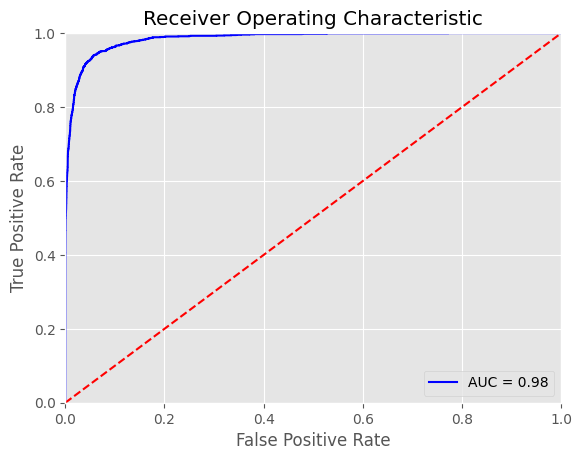

In [ ]:
probs = bert_predict(bert_classifier, val_dataloader)
evaluate_roc(probs, y_val)

<hr style="border:4px solid pink"> </hr>


# Exporter Le Model

In [ ]:
# Créer un dossier pour sauvegarder le modèle
import os
save_directory = "./bert_finetuned"
os.makedirs(save_directory, exist_ok=True)

# Sauvegarder le modèle
torch.save(bert_classifier.state_dict(), os.path.join(save_directory, "model_state_dict.pt"))

# Sauvegarder la configuration du tokenizer et du modèle BERT
bert_classifier.bert.config.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(" Modèle et tokenizer sauvegardés dans", save_directory)


✅ Modèle et tokenizer sauvegardés dans ./bert_finetuned
